# Normalization and batch correction

## Settings

#Path related settings (these should be the same as for the previous notebook)
output_dir = '/home/rstudio/processed_data'
test = 'cropped_146'

In [1]:
# Path related settings (these should be the same as for the previous notebook)
output_dir = '/mnt/workspace/jdetlef/ext_ana/processed'
test = 'all'

In [2]:
# choose normalization method. If None, two normalization methods will be 
# performed and visualized with pca plot
norm_method='total'  # can be 'tfidf' or 'total'
# remove_pc1: if True, the first PC is removed from TFIDF-LSI normalization before calculating neighbors, 
# since first component correlates with number of features
remove_pc1 = True
log_normalize=True

# Highly Variable Features options 
min_cells = 5
max_cells = None

# UMAP related settings 
metacol = 'Sample'

# batch correction: If True, several batch correction methods will be performed,
# you can choose the best one after
batch_column = "batch"
perform_batch_correction = False
batch_methods = ["bbknn", "mnn", "harmony", "scanorama"]

# save figures
save_figs = False

## Loading packages and setup

In [3]:
# sctoolbox modules
import sctoolbox.atac_tree as sub_tree
import sctoolbox.creators as cr
import sctoolbox.annotation as an
from sctoolbox.qc_filter import *
import sctoolbox.plotting as pl
from sctoolbox.atac_utils import *
from sctoolbox.analyser import *
import sctoolbox.atac as atac
# import episcanpy
import scanpy as sc
import episcanpy as epi
#from episcanpy.preprocessing import _decomposition
import numpy as np

## Setup path handling object 

In [4]:
# make an instance of the class
tree = sub_tree.ATAC_tree()
# set processing/output directory
tree.processing_dir = output_dir
# set sample/experiment.. 
tree.run = test

all directories existing
all directories existing


## Load anndata 

In [5]:
# probably updated in future
qc_output = tree.qc_anndata  # path to qc_adata should be here
adata = epi.read_h5ad(qc_output)
adata

AnnData object with n_obs × n_vars = 58173 × 148517
    obs: 'chr1_reads', 'chr10_reads', 'chr11_reads', 'chr12_reads', 'chr13_reads', 'chr14_reads', 'chr15_reads', 'chr16_reads', 'chr17_reads', 'chr18_reads', 'chr19_reads', 'chr2_reads', 'chr3_reads', 'chr4_reads', 'chr5_reads', 'chr6_reads', 'chr7_reads', 'chr8_reads', 'chr9_reads', 'chrM_reads', 'chrX_reads', 'chrY_reads', 'total_genome_reads', 'insertsize_mean', 'Sample', 'id', 'condition', 'date', 'file', 'sample', 'n_features_by_counts', 'log1p_n_features_by_counts', 'total_counts', 'log1p_total_counts', 'insertsize_count', 'mean_insertsize', 'nb_features', 'log_nb_features'
    var: 'peak_chr', 'peak_start', 'peak_end', 'peak_id', 'peak_score', 'peak_strand', 'feature', 'gene_start', 'gene_end', 'gene_strand', 'gene_anchor', 'distance_to_gene', 'relative_location_to_gene', 'gene_ovl_peak', 'peak_ovl_gene', 'gene_biotype', 'gene_id', 'gene_name', 'annotation_query', 'region_length', 'n_cells_by_counts', 'mean_counts', 'log1p_mean

## Find highly variable features

In [6]:
adata.var 

,peak_chr,peak_start,peak_end,peak_id,peak_score,peak_strand,feature,gene_start,gene_end,gene_strand,...,annotation_query,region_length,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,n_cells,commonness
annotated_peaks_0_chr1:3050427-3050801,chr1,3050427,3050801,peak_1,.,.,NaN,NaN,NaN,NaN,...,NaN,374,274,0.006437,0.006416,99.658852,517.0,6.249975,187,274.0
annotated_peaks_100000_chr4:129518038-129518515,chr4,129518038,129518515,peak_100001,.,.,gene,129513066.0,129517740.0,-,...,protein_coding_promoter,477,7932,0.226976,0.204552,90.124133,18230.0,9.810879,4464,7932.0
annotated_peaks_100001_chr4:129518849-129519134,chr4,129518849,129519134,peak_100002,.,.,gene,129513066.0,129517740.0,-,...,protein_coding_promoter,285,1788,0.045221,0.044228,97.773821,3632.0,8.197814,1068,1788.0
annotated_peaks_100002_chr4:129527627-129527883,chr4,129527627,129527883,peak_100003,.,.,gene,129519870.0,129534858.0,-,...,protein_coding_internal,256,289,0.006898,0.006874,99.640176,554.0,6.318968,137,289.0
annotated_peaks_100003_chr4:129533947-129534180,chr4,129533947,129534180,peak_100004,.,.,gene,129519870.0,129534858.0,-,...,protein_coding_promoter,233,1040,0.024017,0.023733,98.705131,1929.0,7.565275,535,1040.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
annotated_peaks_99999_chr4:129517580-129517846,chr4,129517580,129517846,peak_100000,.,.,gene,129513066.0,129517740.0,-,...,protein_coding_promoter,266,2128,0.049890,0.048685,97.350499,4007.0,8.296047,1156,2128.0
annotated_peaks_9999_chr1:192477325-192477572,chr1,192477325,192477572,peak_10000,.,.,gene,192179018.0,192453531.0,-,...,protein_coding_distal,247,521,0.012849,0.012767,99.351320,1032.0,6.940222,295,521.0
annotated_peaks_999_chr1:37026210-37026612,chr1,37026210,37026612,peak_1000,.,.,gene,37065676.0,37226694.0,+,...,protein_coding_distal,402,507,0.012538,0.012460,99.368751,1007.0,6.915723,300,507.0
annotated_peaks_99_chr1:7849890-7850111,chr1,7849890,7850111,peak_100,.,.,gene,7799084.0,7800789.0,-,...,any_gene_distal,221,229,0.005416,0.005401,99.714880,435.0,6.077642,163,229.0


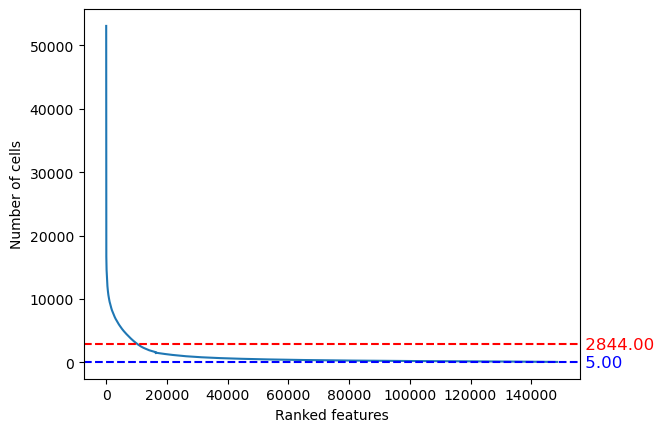

In [7]:
# update number of cells per feature
adata = analyser.calculate_qc_metrics(adata, var_type='features')
# get highly variable features
atac.get_variable_features(adata, max_cells, min_cells)

In [8]:
#Number of variable genes selected
adata.var["highly_variable"].sum()

138117

In [9]:
adata.var

,peak_chr,peak_start,peak_end,peak_id,peak_score,peak_strand,feature,gene_start,gene_end,gene_strand,...,region_length,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,n_cells,commonness,highly_variable
annotated_peaks_0_chr1:3050427-3050801,chr1,3050427,3050801,peak_1,.,.,NaN,NaN,NaN,NaN,...,374,187,0.003215,0.003209,99.678545,187.0,5.236442,187,274.0,True
annotated_peaks_100000_chr4:129518038-129518515,chr4,129518038,129518515,peak_100001,.,.,gene,129513066.0,129517740.0,-,...,477,4464,0.076737,0.073935,92.326337,4464.0,8.404024,4464,7932.0,False
annotated_peaks_100001_chr4:129518849-129519134,chr4,129518849,129519134,peak_100002,.,.,gene,129513066.0,129517740.0,-,...,285,1068,0.018359,0.018193,98.164097,1068.0,6.974479,1068,1788.0,True
annotated_peaks_100002_chr4:129527627-129527883,chr4,129527627,129527883,peak_100003,.,.,gene,129519870.0,129534858.0,-,...,256,137,0.002355,0.002352,99.764496,137.0,4.927254,137,289.0,True
annotated_peaks_100003_chr4:129533947-129534180,chr4,129533947,129534180,peak_100004,.,.,gene,129519870.0,129534858.0,-,...,233,535,0.009197,0.009155,99.080329,535.0,6.284134,535,1040.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
annotated_peaks_99999_chr4:129517580-129517846,chr4,129517580,129517846,peak_100000,.,.,gene,129513066.0,129517740.0,-,...,266,1156,0.019872,0.019677,98.012824,1156.0,7.053586,1156,2128.0,True
annotated_peaks_9999_chr1:192477325-192477572,chr1,192477325,192477572,peak_10000,.,.,gene,192179018.0,192453531.0,-,...,247,295,0.005071,0.005058,99.492892,295.0,5.690360,295,521.0,True
annotated_peaks_999_chr1:37026210-37026612,chr1,37026210,37026612,peak_1000,.,.,gene,37065676.0,37226694.0,+,...,402,300,0.005157,0.005144,99.484297,300.0,5.707110,300,507.0,True
annotated_peaks_99_chr1:7849890-7850111,chr1,7849890,7850111,peak_100,.,.,gene,7799084.0,7800789.0,-,...,221,163,0.002802,0.002798,99.719801,163.0,5.099866,163,229.0,True


In [10]:
reset_cutoffs_dec = input('Do you want to change the cutoffs again: ')

Do you want to change the cutoffs again: no


In [11]:
if reset_cutoffs_dec.lower() == 'yes':
    min_cells = input('Enter the minimal number of cells per feature?: ')
    max_cells = input('Enter the maximum number of cells per feature?: ')
    min_cells = int(min_cells)
    max_cells = int(max_cells)
    adata.var["highly_variable"] = (adata.var['n_cells_by_counts'] <= max_cells) & (adata.var['n_cells_by_counts'] >= min_cells)
    print('Number of highly variable features: ' + str(adata.var["highly_variable"].sum()))

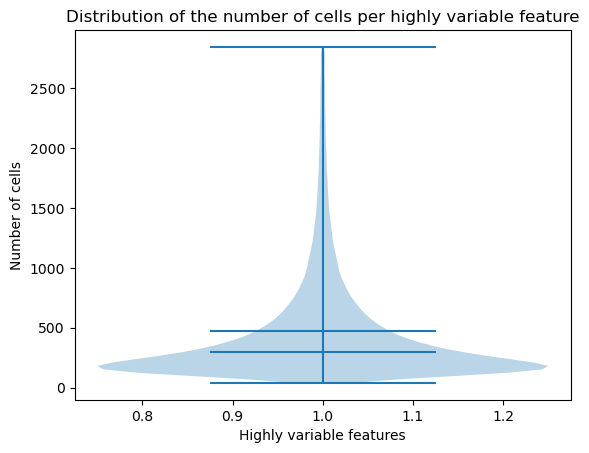

In [12]:
violin_HVF_distribution(adata)

## Normalization

In [13]:
# Consider using parts of sctoolbox.analyser

In [14]:
if norm_method == 'tfidf':
    print('Performing TFIDF and LSI...')
    atac.tfidf(adata)
    atac.lsi(adata)
    if remove_pc1:
        adata.obsm['X_lsi'] = adata.obsm['X_lsi'][:,1:]
        adata.varm["LSI"] = adata.varm["LSI"][:,1:]
        adata.uns["lsi"]["stdev"] = adata.uns["lsi"]["stdev"][1:]
        adata.obsm['X_pca'] = adata.obsm['X_pca'][:,1:]
        adata.varm["PCs"] = adata.varm["PCs"][:,1:]
        adata.uns["pca"]["stdev"] = adata.uns["pca"]["stdev"][1:]
    print('Done')
if norm_method == 'total':
    print('Performing total and log1p normalization...')
    sc.pp.normalize_total(adata)
    adata.layers['normalised'] = adata.X.copy()
    if log_normalize:
        epi.pp.log1p(adata)
    print('Done')
if not norm_method:
    adata_tfidf, adata_total = atac.atac_norm(adata, remove_pc1=remove_pc1)

Performing total and log1p normalization...
Done


In [15]:
if not norm_method:
    user_norm = input('Choose a normalization method (total or tfidf): ')
    if user_norm == 'total':
        adata = adata_total
    elif user_norm == 'tfidf':
        adata = adata_tfidf
else:
    user_norm = None
    
display(adata)

AnnData object with n_obs × n_vars = 58173 × 148517
    obs: 'chr1_reads', 'chr10_reads', 'chr11_reads', 'chr12_reads', 'chr13_reads', 'chr14_reads', 'chr15_reads', 'chr16_reads', 'chr17_reads', 'chr18_reads', 'chr19_reads', 'chr2_reads', 'chr3_reads', 'chr4_reads', 'chr5_reads', 'chr6_reads', 'chr7_reads', 'chr8_reads', 'chr9_reads', 'chrM_reads', 'chrX_reads', 'chrY_reads', 'total_genome_reads', 'insertsize_mean', 'Sample', 'id', 'condition', 'date', 'file', 'sample', 'n_features_by_counts', 'log1p_n_features_by_counts', 'total_counts', 'log1p_total_counts', 'insertsize_count', 'mean_insertsize', 'nb_features', 'log_nb_features'
    var: 'peak_chr', 'peak_start', 'peak_end', 'peak_id', 'peak_score', 'peak_strand', 'feature', 'gene_start', 'gene_end', 'gene_strand', 'gene_anchor', 'distance_to_gene', 'relative_location_to_gene', 'gene_ovl_peak', 'peak_ovl_gene', 'gene_biotype', 'gene_id', 'gene_name', 'annotation_query', 'region_length', 'n_cells_by_counts', 'mean_counts', 'log1p_mean

## PCA

In [ ]:
if norm_method == 'total':
    print('Performing PCA')
    sc.pp.pca(adata, svd_solver='arpack', n_comps=50, use_highly_variable=True)
    print('Done')

Performing PCA


### Plot PCA

In [ ]:
if norm_method == 'tfidf' or user_norm == 'tfidf':
    # Change to module
    if save_figs:
        epi.pl.pca(adata, color=['nb_features'], show=False)
        #plt.savefig(f'{OUTPUT_FIGS}/pca_nb_features.png')
        plt.show()
    else:
        epi.pl.pca(adata, color=['nb_features'])
        
elif norm_method == 'total':
    if save_figs:
        epi.pl.pca_overview(adata, color=['nb_features'], show=False)
        #plt.savefig(f'{OUTPUT_FIGS}/pca_nb_features.png')
        plt.show()
    else:
        epi.pl.pca_overview(adata, color=['nb_features'])

## Calc Neighbours

In [ ]:
if norm_method:
    if norm_method == 'tfidf' and remove_pc1:
        print('Calculating neighbors')
        sc.pp.neighbors(adata, n_neighbors=10, n_pcs=30, method='umap', metric='euclidean')
    else:
        print('Calculating neighbors')
        sc.pp.neighbors(adata, n_neighbors=15, n_pcs=50, method='umap', metric='euclidean')
    print('Done')

## UMAP

In [ ]:
pl.search_umap_parameters(adata, 
                       dist_range=(0.1, 0.4, 0.1), 
                       spread_range=(2.0, 3.0, 0.5), 
                       metacol=metacol, 
                       n_components=2, 
                       verbose=True, 
                       threads=4, 
                       save=None)

## Batch correction

# !! THIS IS CURRENTLY NOT WORKING!!

In [ ]:
#adata.obs['batch'] = 1

In [ ]:
##adata.obs['batch']

In [ ]:
#adata.obs[batch_column] = adata.obs[batch_column].astype("category") #ensure that batch column is a category

In [ ]:
#if perform_batch_correction:
#    batch_corrections = analyser.wrap_corrections(adata, 
#                                              batch_key=batch_column,
#                                              methods=batch_methods)
#else:
#    batch_corrections = {"uncorrected": adata}

In [ ]:
##Run standard umap for all adatas
#analyser.wrap_umap(batch_corrections.values(), threads=threads)

In [ ]:
## Should preliminary clustering be performed?
#do_clustering = True #True or False

In [ ]:
##Perform additional clustering if it was chosen
#if do_clustering:
#    for adata in batch_corrections.values():
#        sc.tl.leiden(adata)
#    color_by.append("leiden")

In [ ]:
## Calculate LISI scores for batch
#analyser.wrap_batch_evaluation(batch_corrections, batch_key=batch_column, threads=threads, inplace=True)

In [ ]:
##Plot the overview of batch correction methods
#_ = pl.anndata_overview(batch_corrections, color_by=color_by, 
#                        output=figure_path + "batch_correction_overview.pdf")

## save anndata

In [ ]:
adata_output = tree.norm_correction_anndata
adata.write(filename=adata_output)

In [ ]:
import os
import shutil
repo_path = os.getcwd()
notebook_name = '3_normalization_batch_correction'
notebook_path = os.path.join(repo_path, notebook_name)
notebook_copy = os.path.join(tree.norm_correction_dir , notebook_name)
shutil.copyfile(notebook_path, notebook_copy)